# 💧 LFM2.5-VL - SFT with Unsloth

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://unsloth.ai/docs/get-started/install).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & how to save it

### News


Train MoEs - DeepSeek, GLM, Qwen and gpt-oss faster with 32% less VRAM. [Blog](https://unsloth.ai/docs/new/faster-moe)

You can now train embedding models 1.8-3.3x faster with 20% less VRAM. [Blog](https://unsloth.ai/docs/new/embedding-finetuning)

Ultra Long-Context Reinforcement Learning is here with 7x more context windows! [Blog](https://unsloth.ai/docs/new/grpo-long-context)

3x faster LLM training with 30% less VRAM and 500K context. [3x faster](https://unsloth.ai/docs/new/3x-faster-training-packing) • [500K Context](https://unsloth.ai/docs/new/500k-context-length-fine-tuning)

New in Reinforcement Learning: [FP8 RL](https://unsloth.ai/docs/new/fp8-reinforcement-learning) • [Vision RL](https://unsloth.ai/docs/new/vision-reinforcement-learning-vlm-rl) • [Standby](https://unsloth.ai/docs/basics/memory-efficient-rl) • [gpt-oss RL](https://unsloth.ai/docs/new/gpt-oss-reinforcement-learning)

Visit our docs for all our [model uploads](https://unsloth.ai/docs/get-started/unsloth-model-catalog) and [notebooks](https://unsloth.ai/docs/get-started/unsloth-notebooks).


### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth  # Do this in local & cloud setups
else:
    import torch; v = re.match(r'[\d]{1,}\.[\d]{1,}', str(torch.__version__)).group(0)
    xformers = 'xformers==' + {'2.10':'0.0.34','2.9':'0.0.33.post1','2.8':'0.0.32.post2'}.get(v, "0.0.34")
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth_zoo bitsandbytes accelerate {xformers} peft trl triton unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

### Unsloth

In [ ]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "LiquidAI/LFM2.5-VL-1.6B",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = False, # 4 bit quantization to reduce memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.8: Fast Lfm2 patching. Transformers: 5.0.0.dev0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading weights:   0%|          | 0/589 [00:00<?, ?it/s]

We now add LoRA adapters so we only need to update a small amount of parameters!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Set to False for now
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR). LFM-VL renders ChatML conversations with images like below:

```
<|startoftext|><|im_start|>system
You are a helpful multimodal assistant by Liquid AI.<|im_end|>
<|im_start|>user
<image>Describe this image.<|im_end|>
<|im_start|>assistant
This image shows a Caenorhabditis elegans (C. elegans) nematode.<|im_end|>
```

In [ ]:
tokenizer.apply_chat_template([
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What's in this image?"}
        ]
    },
    {"role": "assistant", "content": "I can see a cat sitting on a couch."}
], tokenize = False)

"<|startoftext|><|im_start|>user\n<image>What's in this image?<|im_end|>\n<|im_start|>assistant\nI can see a cat sitting on a couch.<|im_end|>\n"

We get the first 3000 rows of the dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train[:3000]")

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 3000
})

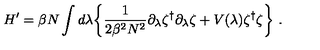

In [ ]:
dataset[2]["image"]

In [ ]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [ ]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

We look at how the conversations are structured for the first example:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \Big \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \Big \} \ .<|im_end|>


<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support `DPOTrainer` and `GRPOTrainer` for reinforcement learning!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
3.109 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 9,142,272 of 1,605,768,176 (0.57% trained)

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.034994
2,1.812485
3,2.046704
4,1.447800
5,1.189059
6,1.311097
7,1.018903
8,1.125553
9,1.021464
10,1.180838


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

88.8178 seconds used for training.
1.48 minutes used for training.
Peak reserved memory = 3.639 GB.
Peak reserved memory for training = 0.53 GB.
Peak reserved memory % of max memory = 16.421 %.
Peak reserved memory for training % of max memory = 2.392 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.



In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \Big \{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \Big \} \ .<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Hugging Face's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lfm_lora")  # Local saving
tokenizer.save_pretrained("lfm_lora")
# model.push_to_hub("your_name/lfm_lora", token = "YOUR_HF_TOKEN") # Online saving
# tokenizer.push_to_hub("your_name/lfm_lora", token = "YOUR_HF_TOKEN") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lfm_lora", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

\frac { N } { M } \in { \bf Z } , \frac { M } { P } \in { \bf Z } , \frac { P } { Q } \in { \bf Z }<|im_end|>


### Saving to float16 for vLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens. See [our docs](https://unsloth.ai/docs/basics/inference-and-deployment) for more deployment options.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "YOUR_HF_TOKEN")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [docs page](https://unsloth.ai/docs/basics/inference-and-deployment/saving-to-gguf#locally)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("lfm_finetune", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("HF_USERNAME/lfm_finetune", tokenizer, token = "YOUR_HF_TOKEN")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("lfm_finetune", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("HF_USERNAME/lfm_finetune", tokenizer, quantization_method = "f16", token = "YOUR_HF_TOKEN")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("lfm_finetune", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("HF_USERNAME/lfm_finetune", tokenizer, quantization_method = "q4_k_m", token = "YOUR_HF_TOKEN")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "HF_USERNAME/lfm_finetune", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "YOUR_HF_TOKEN",
    )

Now, use the `lfm_finetune.Q8_0.gguf` file or `lfm_finetune.Q4_K_M.gguf` file in llama.cpp.

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other resources:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
4. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://unsloth.ai/docs/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️

  This notebook and all Unsloth notebooks are licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme).
</div>
